### Parse the XML

In [22]:
import xml.etree.ElementTree as ET
import pandas as pd
from dateutil import parser, tz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

tz_local = tz.gettz("Europe/Amsterdam")

def xml_to_df(xml_path):
    rows = []
    for record in ET.parse(xml_path).iterfind(".//Record"):
        rows.append(record.attrib)
    df = pd.DataFrame(rows)

    # standardise column names
    keep = ["type","value","startDate","endDate","sourceName","unit"]
    df = df[keep]
    # convert dates AFTER you load
    df["startDate"] = pd.to_datetime(df["startDate"]).dt.tz_convert(tz_local)
    df["endDate"]   = pd.to_datetime(df["endDate"]).dt.tz_convert(tz_local)
    return df


### Isolate sleep-analysis rows

In [23]:
df_all = xml_to_df("data/export.xml")
sleep = df_all[df_all["type"]=="HKCategoryTypeIdentifierSleepAnalysis"].copy()


### Map Apple’s stage labels to tidy categories

In [24]:
MAP = {
    "HKCategoryValueSleepAnalysisInBed"        : "in_bed",
    "HKCategoryValueSleepAnalysisAwake"        : "awake",
    "HKCategoryValueSleepAnalysisAsleepUnspecified": "asleep_unspecified",
    "HKCategoryValueSleepAnalysisAsleepCore"   : "core",
    "HKCategoryValueSleepAnalysisAsleepREM"    : "rem",
    "HKCategoryValueSleepAnalysisAsleepDeep"   : "deep",
}

sleep["stage"] = sleep["value"].map(MAP)
sleep["duration_m"] = (sleep["endDate"]-sleep["startDate"]).dt.total_seconds()/60


### Collapse per-night hypnogram blocks

In [25]:
sleep["date"] = sleep["startDate"].dt.date
agg = (sleep.pivot_table(index="date",
                         columns="stage",
                         values="duration_m",
                         aggfunc="sum")
              .reset_index())

agg["date"] = pd.to_datetime(agg["date"])     # makes it Timestamp-typed
agg["bedtime"]     = sleep.groupby("date")["startDate"].min().values
agg["wake_time"]   = sleep.groupby("date")["endDate"].max().values
agg["total_in_bed"]= agg["in_bed"]
agg["total_sleep"] = agg[["core","deep","rem","asleep_unspecified"]].sum(axis=1)
agg["efficiency"]  = agg["total_sleep"]/agg["total_in_bed"]


In [26]:
sleep.to_csv("sleep_segments.csv", index=False)
agg.to_csv("sleep_nightly_summary.csv", index=False)


### Hypnogram

In [27]:
def plot_hypnogram(sleep_df: pd.DataFrame, night_date):
    """
    Draws a hypnogram for a single night.

    Parameters
    ----------
    sleep_df    DataFrame with stage-level records (see above).
    night_date  datetime.date (or yyyy-mm-dd string) of the night to plot.
    """
    night_date = pd.to_datetime(night_date).date()
    stages = ["in_bed", "awake", "core", "deep", "rem", "asleep_unspecified"]
    cmap   = {s: i for i, s in enumerate(stages)}        # numeric y-pos

    fig, ax = plt.subplots(figsize=(12, 2.5), constrained_layout=True)
    ax.set_title(f"Hypnogram – {night_date}")

    # Add one broken_barh per sleep segment
    for _, row in sleep_df.query("date == @night_date").iterrows():
        y     = cmap[row.stage] - 0.4
        start = mdates.date2num(row.startDate)
        width = (row.endDate - row.startDate).total_seconds() / 86400  # days
        ax.broken_barh([(start, width)], (y, 0.8))

    # Y-axis ticks / labels
    ax.set_yticks(list(cmap.values()))
    ax.set_yticklabels(stages)
    ax.invert_yaxis()                                   # conventional orientation
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.set_xlabel("Clock time")
    plt.show()


### Stage-share heatmap

In [28]:
def plot_stage_heatmap(agg_df: pd.DataFrame):
    """
    Heat-map of nightly minutes in each sleep stage.

    Expects stage columns in minutes (core, deep, rem, asleep_unspecified, awake).
    """
    stages = ["core", "deep", "rem", "asleep_unspecified", "awake"]
    df_hm  = (agg_df.set_index("date")[stages]
                        .fillna(0)
                        .sort_index())                  # rows by night

    fig, ax = plt.subplots(figsize=(10, max(4, len(df_hm) * 0.18)),
                           constrained_layout=True)
    im = ax.imshow(df_hm.values, aspect="auto")

    # Ticks / labels
    ax.set_xticks(np.arange(len(stages)))
    ax.set_xticklabels(stages, rotation=25, ha="right")
    ax.set_yticks(np.arange(len(df_hm)))
    ax.set_yticklabels(df_hm.index.strftime("%Y-%m-%d"))

    ax.set_title("Minutes per stage (each row = one night)")
    plt.colorbar(im, ax=ax, label="Minutes")
    plt.show()


### Weekly rolling trends

In [29]:
def plot_weekly_trends(agg_df: pd.DataFrame):
    """
    Two-panel chart of 7-day rolling averages:
    – total sleep (h)
    – sleep efficiency
    """
    df = agg_df.set_index("date").sort_index()
    roll = df[["total_sleep", "efficiency"]].rolling(7).mean()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5),
                                   sharex=True, constrained_layout=True)

    # --- total sleep (minutes ➜ hours)
    ax1.plot(roll.index, roll.total_sleep / 60)         # hours
    ax1.set_ylabel("Total sleep (h)")
    ax1.set_title("7-day rolling average")

    # --- efficiency
    ax2.plot(roll.index, roll.efficiency)
    ax2.set_ylabel("Sleep efficiency")
    ax2.set_xlabel("Date")

    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(
        mdates.AutoDateLocator()))
    plt.show()


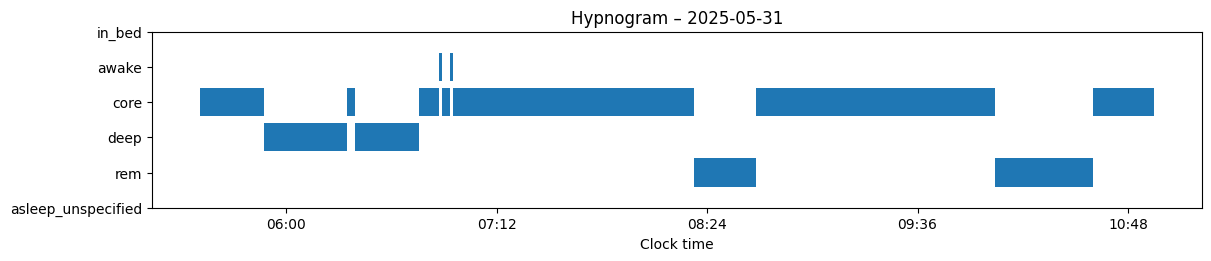

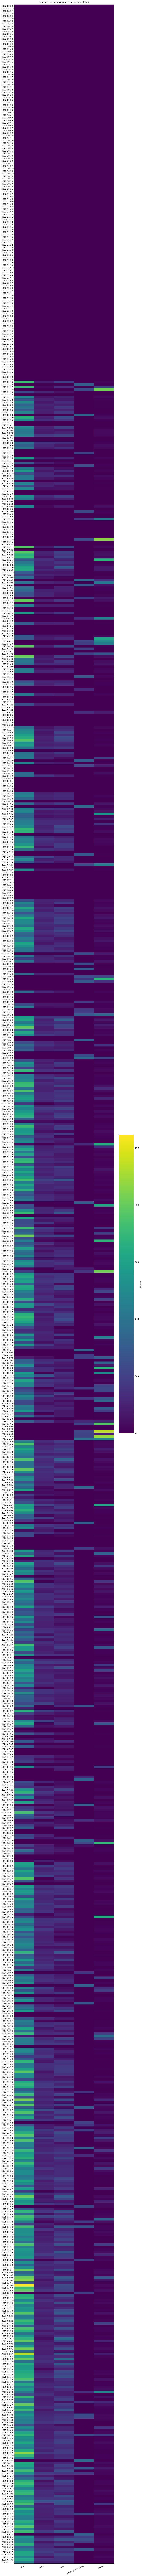

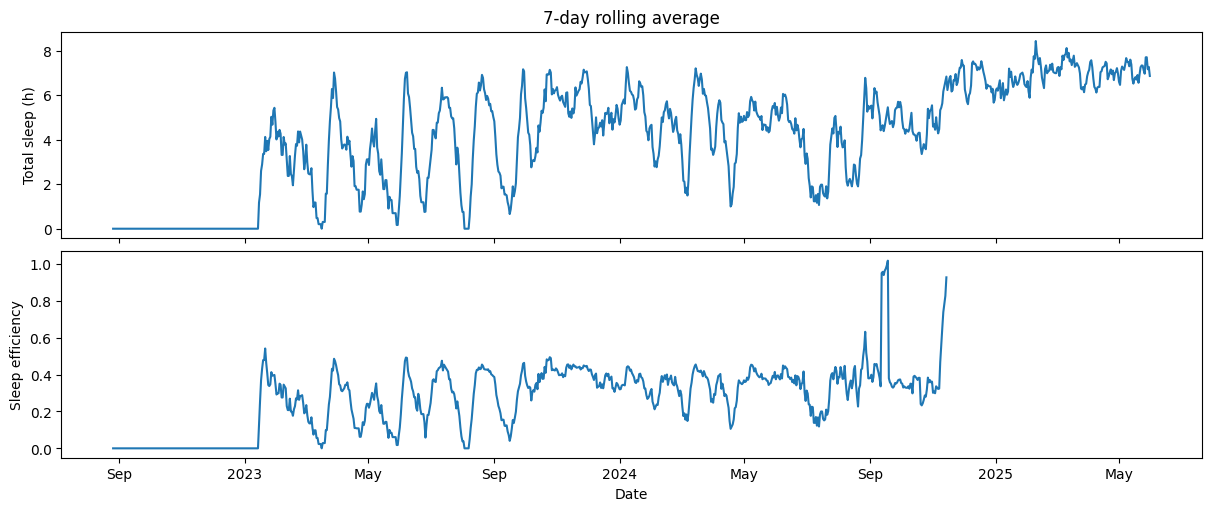

In [30]:
plot_hypnogram(sleep, "2025-05-31")
plot_stage_heatmap(agg)
plot_weekly_trends(agg)